In [190]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from neuro.flatmaps_helper import load_flatmaps
from neuro.features.questions.gpt4 import QS_35_STABLE
import sys
import warnings
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
# flatmaps_per_question = __import__('06_flatmaps_per_question')
import viz
import gemv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### load gemv average flatmaps

In [191]:
list(gemv_flatmaps_dict_S02.keys())

[('birthdays', np.int64(442)),
 ('communication', np.int64(299)),
 ('death', np.int64(155)),
 ('emotion', np.int64(179)),
 ('emotional expression', np.int64(398)),
 ('food preparation', np.int64(79)),
 ('hair and clothing', np.int64(154)),
 ('laughter', np.int64(426)),
 ('locations', np.int64(122)),
 ('locations', np.int64(368)),
 ('measurements', np.int64(171)),
 ('moments', np.int64(337)),
 ('negativity', np.int64(248)),
 ('physical injury or trauma', np.int64(339)),
 ('rejection', np.int64(342)),
 ('surprise', np.int64(168)),
 ('time', np.int64(212)),
 ('abstract descriptions', 'qa'),
 ('cultural references', 'qa'),
 ('dialogue', 'qa'),
 ('industry or profession', 'qa'),
 ('negations', 'qa'),
 ('numbers', 'qa'),
 ('opinions or judgments', 'qa'),
 ('personal or interactions interactions', 'qa'),
 ('personal reflections or thoughts', 'qa'),
 ('personal values or beliefs', 'qa'),
 ('physical actions', 'qa'),
 ('planning or organizing', 'qa'),
 ('proper nouns', 'qa'),
 ('relationships b

In [192]:
for q in QS_35_STABLE:
    if not q in qa_questions_list:
        print("'" + q + "'" + ',')

'Does the input contain a number?',


### make comparisons

In [193]:
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps(
    normalize_flatmaps=False, load_timecourse=False)
# gemv_flatmaps_pilot | gemv_flatmaps_pilot5
gemv_flatmaps_dict = gemv_flatmaps_dict_S02
qa_questions_list, gemv_questions_list = gemv.get_matched_lists()

gemv_flatmaps_dict = gemv.match_flatmaps(gemv_flatmaps_dict)


# # check that gpt4 was run for all the questions
# subject = 'UTS02'
# setting = 'individual_gpt4'
# flatmaps_qa = joblib.load(
#     join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
# for k in qa_list:
#     assert k in flatmaps_qa.keys()

# settings = ['full_35']
# settings = ['full_35_wordrate']
# settings = ['full_35_pc']
# settings = ['full_neurosynth']
# settings = ['full_35_gpt4_pc']
# settings = ['individual_gpt4_pc']
# settings = ['shapley_35_gpt4_pc']
# settings = ['shapley_35', 'individual_gpt4_pc', 'shapley_35_gpt4_pc']
# settings = ['individual_gpt4_ndel=1_pc']
# settings = ['full_35_gpt4_ndel=1_pc']
# settings = ['full_35_ndel=8_pc']
# settings = ['full_35', 'full_35_wordrate']
# settings = ['individual_gpt4', 'individual_gpt4_wordrate',]
settings = ['individual_gpt4', 'individual_gpt4_wordrate', 'shapley_35']
# settings = ['shapley_35']
# settings = ['individual_35']
# settings = ['individual_gpt4']
# , 'individual_35', full_35', 'shapley_35', 'individual_gpt4',
# for setting in ['individual_gpt4', 'shapley_35']:
# for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
# , 'shapley_35']:
# for setting in ['individual_gpt4']:
# for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
# , 'individual_gpt4', 'individual_gpt4_wordrate']:

# corrs_mask_per_question = False
corrs_mask_per_question = False

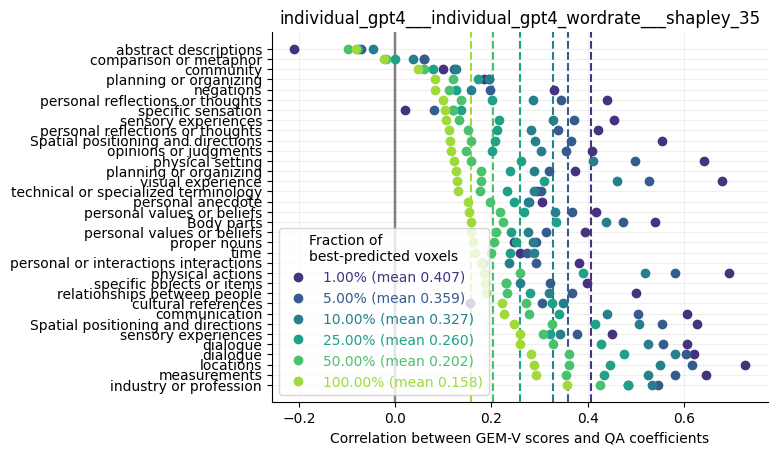

In [194]:
# load qa weights
subject = 'UTS02'
corrs_df_dict = {}
frac_voxels_to_keep_list = [0.01, 0.05, 0.1, 0.25, 0.5, 1]

# corrs used for masking
corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
    'UT', ''), 'corrs_test_35.pkl')).values[0]
corrs_test_individual_dict = joblib.load(join(PROCESSED_DIR, subject.replace(
    'UT', ''), 'corrs_test_individual_gpt4_qs_35.pkl'))

for j, frac_voxels_to_keep in enumerate(frac_voxels_to_keep_list):
    flatmaps_qa_list = defaultdict(list)
    for setting in settings:
        flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    # print('lens', [len(flatmaps_qa_list[q]) for q in flatmaps_qa_list.keys()])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        # q: np.max(flatmaps_qa_list[q], axis=0)
        # q: np.median(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()}

    # select what to plot
    # df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')
    questions_names_df = pd.DataFrame({
        'qa': qa_questions_list,
        'gemv': gemv_questions_list,
    })
    # filter only questions that exist in the flatmaps
    questions_names_df = questions_names_df[questions_names_df['qa'].isin(
        flatmaps_qa_dict.keys())]

    if isinstance(flatmaps_qa_dict, pd.DataFrame):
        questions_names_df = questions_names_df[questions_names_df['qa'].isin(
            flatmaps_qa_dict.index)]
        flatmaps_qa_list = flatmaps_qa_dict.loc[questions_names_df['qa'].values]['weights'].values
    else:
        flatmaps_qa_list = [flatmaps_qa_dict[q]
                            for q in questions_names_df['qa'].values]
    flatmaps_gemv_list = [
        gemv_flatmaps_dict[q]
        for q in questions_names_df['gemv'].values]
    titles_gt = questions_names_df['gemv'].apply(
        lambda x: x[0]).astype(str)

    # mask flatmaps by corr
    # corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
    #     'UT', ''), 'corrs_test_35.pkl')).values[0]
    # corrs_test_mask = (corrs_test >= np.percentile(
    #     corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)

    # flatmaps_qa = [flatmaps_qa[i][corrs_test_mask]
    #                for i in range(len(flatmaps_qa))]
    # flatmaps_gemv = [flatmaps_gemv[i][corrs_test_mask]
    #                  for i in range(len(flatmaps_gemv))]

    # mask flatmaps by extreme vals
    for i in range(len(flatmaps_qa_list)):
        if frac_voxels_to_keep < 1:
            # mask based on extreme values
            # mask = np.abs(flatmaps_qa_list[i]) >= np.percentile(
            #     np.abs(flatmaps_qa_list[i]), 100 * (1 - frac_voxels_to_keep))

            # mask based on corrs
            if corrs_mask_per_question:
                q = questions_names_df['qa'].values[i]
                mask = (corrs_test_individual_dict[q] > np.percentile(
                    corrs_test_individual_dict[q], 100 * (1 - frac_voxels_to_keep))).astype(bool)
            else:
                mask = (corrs_test > np.percentile(
                    corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)
        else:
            mask = np.ones_like(flatmaps_qa_list[i]).astype(bool)

        flatmaps_qa_list[i] = flatmaps_qa_list[i][mask]
        flatmaps_gemv_list[i] = flatmaps_gemv_list[i][mask]

    # # save flatmaps
    # if frac_voxels_to_keep in [0.1, 1]:

    #     # apply mask as nans
    #     for i in range(len(flatmaps_qa)):
    #         flatmaps_qa[i][~corrs_test_mask] = np.nan
    #         flatmaps_gemv[i][~corrs_test_mask] = np.nan

    #     for i in tqdm(range(len(flatmaps_qa))):
    #         sasc.viz.quickshow(
    #             flatmaps_qa[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             setting, f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    #         sasc.viz.quickshow(
    #             flatmaps_gemv[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             'gemv', f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    # shuffle gemv
    # random.shuffle(flatmaps_gemv)

    # print num nas
    # print('nas', [np.isnan(flatmaps_gemv[i]).sum()
    #   for i in range(len(flatmaps_gemv))])

    corrs_mat = viz._calc_corrs(
        flatmaps_qa_list,
        flatmaps_gemv_list,
        titles_qa=[analyze_helper.abbrev_question(q)
                   for q in questions_names_df['qa'].astype(str)],
        titles_gt=titles_gt,
    )
    # corrs_df = pd.DataFrame({'corrs': np.diag(
    # corrs.values), 'questions': corrs.columns}).sort_values('corrs', ascending=False)
    # corrs_df_dict[frac_voxels_to_keep] = corrs_df.copy()
    corrs_df_dict['questions'] = corrs_mat.columns
    corrs_df_dict[f'corrs_{frac_voxels_to_keep}'] = np.diag(corrs_mat.values)


# actually make plot
corrs_df = pd.DataFrame(corrs_df_dict)
corrs_df = corrs_df.sort_values('corrs_1', ascending=False)
# corrs_df.to_pickle(join(repo_dir, 'qa_results', 'gemv',
# setting + '_corrs_df.pkl'))
for j, frac_voxels_to_keep in enumerate(frac_voxels_to_keep_list):
    colors = sns.color_palette('viridis', len(frac_voxels_to_keep_list))
    viz.corr_bars(
        corrs_df['corrs_' + str(frac_voxels_to_keep)],
        questions=corrs_df['questions'],
        out_dir_save=join(repo_dir, 'qa_results', 'gemv',
                          'corrs_' + setting),
        xlab='Correlation between GEM-V scores and QA coefficients',
        color=colors[j],
        label=f'{frac_voxels_to_keep * 100:.2f}%',
    )
    # plt.savefig(join(out_dir_save, 'corrs_barplot.pdf'), bbox_inches='tight')
    # plt.savefig(join(out_dir_save, 'corrs_barplot.png'),
    #             bbox_inches='tight', dpi=300)
    # plt.show()

plt.title('___'.join(settings))
# center legend text
plt.legend(title='Fraction of\nbest-predicted voxels',
           labelcolor='linecolor')
# plt.tight_layout()
# plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, 'corrs_barplot.pdf'),
# bbox_inches='tight')
out_fname = 'corrs_' + '___'.join(settings)
if corrs_mask_per_question:
    out_fname += '_mask_per_question'
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, out_fname + '.pdf'),
            bbox_inches='tight', dpi=300)
joblib.dump(corrs_df, join(repo_dir, 'qa_results', 'gemv',
                           subject, out_fname + '.pkl'))
plt.show()

In [195]:
corrs_df

,questions,corrs_0.01,corrs_0.05,corrs_0.1,corrs_0.25,corrs_0.5,corrs_1
7,industry or profession,0.484911,0.545333,0.533160,0.484740,0.426602,0.356287
1,measurements,0.646869,0.581266,0.526034,0.434947,0.354679,0.293160
2,locations,0.727854,0.617503,0.549756,0.445887,0.361092,0.288093
31,dialogue,0.621610,0.605002,0.580742,0.476051,0.361910,0.282815
6,dialogue,0.606055,0.556876,0.525724,0.428355,0.327143,0.259636
25,sensory experiences,0.449804,0.377581,0.341750,0.321860,0.307877,0.259555
29,Spatial positioning and directions,0.627821,0.555213,0.507804,0.415940,0.326513,0.247556
3,communication,0.607142,0.505605,0.441113,0.340346,0.278727,0.225469
5,cultural references,0.156362,0.304745,0.348302,0.325171,0.271822,0.221440
16,relationships between people,0.500309,0.367959,0.320708,0.281189,0.232698,0.189702


In [146]:
# aggregate results
corrs_results_dir = join(repo_dir, 'qa_results', 'gemv', subject)
d = defaultdict(list)
for fname in os.listdir(corrs_results_dir):
    if fname.startswith('corrs_') and fname.endswith('.pkl'):
        d['setting'].append(fname.replace('corrs_', '').replace('.pkl', ''))
        x = joblib.load(join(corrs_results_dir, fname))
        d['corrs_df'].append(joblib.load(join(corrs_results_dir, fname)))
        if not len(x) == len(gemv_questions_list):
            warnings.warn(
                'not all questions were computed for ' + str(d['setting'][-1]))
# assert all([x.shape[0] == d['corrs_df'][0].shape[0] for x in d['corrs_df']])
avg_df = pd.DataFrame([x.drop(columns='questions').mean(axis=0)
                      for x in d['corrs_df']], index=d['setting'])
avg_df = avg_df.sort_values(by='corrs_1', ascending=False)
avg_df.style.background_gradient(cmap='viridis').format("{:.3f}")

/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for full_35_gpt4_ndel=1_pc
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for full_35_wordrate
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for individual_gpt4_pc_mask_per_question
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for full_neurosynth
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for full_35_gpt4_pc
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for full_35_gpt4_pc___individual_gpt4_pc___shapley_35_gpt4_pc
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questions were computed for individual_gpt4
  warnings.warn(
/tmp/ipykernel_3580036/3664055931.py:10: UserWarning: not all questi

,corrs_0.001,corrs_0.01,corrs_0.05,corrs_0.1,corrs_0.25,corrs_0.5,corrs_1
individual_gpt4___individual_gpt4_wordrate___shapley_35,nan,0.431,0.379,0.344,0.275,0.213,0.166
shapley_35___individual_gpt4_pc___shapley_35_gpt4_pc,0.394,0.361,0.301,0.265,0.207,0.160,0.126
individual_gpt4,0.400,0.359,0.309,0.274,0.212,0.160,0.123
individual_gpt4___individual_gpt4_wordrate,nan,0.351,0.300,0.265,0.206,0.157,0.122
shapley_35,0.368,0.325,0.268,0.232,0.185,0.147,0.118
full_35_gpt4_pc___individual_gpt4_pc___shapley_35_gpt4_pc,0.392,0.350,0.290,0.255,0.197,0.150,0.117
individual_gpt4_pc,0.387,0.353,0.298,0.264,0.202,0.151,0.116
individual_gpt4_pc_mask_per_question,0.333,0.325,0.289,0.254,0.198,0.157,0.116
shapley_35_gpt4_pc,0.375,0.330,0.269,0.236,0.185,0.143,0.112
individual_gpt4_ndel=1_pc,0.397,0.358,0.293,0.256,0.193,0.141,0.103


### compute p-values with eng1000

In [ ]:
for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    eng1000_dir = join(PROCESSED_DIR, subject.replace(
        'UT', ''), 'eng1000_weights.pkl')
    pvals = viz.compute_pvals(flatmaps_qa_list, frac_voxels_to_keep,
                              corrs_df[f'corrs_{frac_voxels_to_keep}'].values, eng1000_dir=eng1000_dir, mask_corrs=corrs_test)

    # get what fraction of 'corrs_perm_eng1000' column is greater than 'corrs'
    corrs_df[f'pval_{frac_voxels_to_keep}'] = pvals

In [ ]:
# add average row
corrs_viz = corrs_df.set_index('questions').sort_values(
    by='pval_0.001')
# by='corrs_1')
corrs_viz.loc['AVG'] = corrs_viz.mean()
corrs_viz.loc['AVG_FIRST10'] = corrs_viz.head(10).mean()

# format scientific notation
print('___'.join(settings))
corrs_viz.style.background_gradient().format(precision=3)

In [ ]:
from ridge_utils.SemanticModel import SemanticModel
from neuro.config import em_data_dir
eng1000 = SemanticModel.load(join(em_data_dir, "english1000sm.hf5"))

In [ ]:
word_to_index_dict = eng1000.vindex

index_to_wordlist_dict = defaultdict(list)
for k, v in word_to_index_dict.items():
    index_to_wordlist_dict[v].append(k.decode())
# check if all lists are length 1
assert all([len(v) == 1 for v in index_to_wordlist_dict.values()])

In [ ]:
words_list_985 = list(word_to_index_dict.keys())
dog_vec = eng1000['dog'.encode()]
words_list_985[np.argmax(dog_vec) + 1]

In [ ]:
for k in corrs_viz.index.values[:-2]:
    first_word = k.split()[0]
    if first_word.endswith('s'):
        first_word = first_word[:-1]
    rename = {
        'measurement': 'measure',
        'dialogue': 'talk',
        'sensory': 'sense',
        'negation': 'negative',
        'cultural': 'culture',
    }
    first_word = rename.get(first_word, first_word)

    print(k, '--', first_word,
          eng1000.find_words_like_word(first_word.encode(), n=100))

# Look at merged flatmaps

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results', 'gemv',
                               setting + '_corrs_df.pkl'))

In [ ]:
img_parent_dir = join(repo_dir, 'qa_results', 'gemv',
                      subject, 'frac_voxels=0.1')
img_dir1 = join(img_parent_dir, 'gemv')
img_dir2 = join(img_parent_dir, setting)

# read images and combine them with their filenames on a single plot
# fnames = os.listdir(img_dir1)
# fnames = [f for f in fnames if f.endswith('.png')]
# only keep the ones that are in both directories
# fnames = [f for f in fnames if f in os.listdir(img_dir2)]


# corrs = corrs.sort_values('corrs', ascending=False)
fnames = [v + '.png' for v in corrs_df['questions'].values]

n = len(fnames)
C = 4
R = int(np.ceil(n / C))

fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].axis('off')
for i, fname in enumerate(fnames):
    img1 = plt.imread(join(img_dir1, fname))
    img2 = plt.imread(join(img_dir2, fname))
    axs[i].imshow(np.concatenate([img1, img2], axis=1))
    axs[i].set_title(
        f'{fname[:-4]} ({corrs_df["corrs"].values[i]:0.3f})', fontsize=8)

# add text in bottom right of figure
fig.text(0.99, 0.01, f'{subject}\nGEMV on left, QA on right',
         ha='right', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig(join(img_parent_dir, f'flatmaps_{setting}_{subject}.png'), dpi=300)
plt.close()